<a href="https://colab.research.google.com/github/nyp-sit/iti107-2024s2/blob/main/session-7/blip_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %%capture
# !pip install matplotlib transformers datasets accelerate sentence-transformers

#Multimodal Large Language Model

BLIP-2, LLaVA, and other Visual LLMs project the visual features from images to language embeddings, using CLIP-like visual encoders.The language embeddings can then be used as input for an LLM that they can be used as the input for an LLM.  This capability enabled interesting use cases such as image captioning and visual Q&A.

In this exercise, we will learn how to use the BLIP-2 to perform image captioning and visual Q&A tasks.

## BLIP-2 model

Let's just load the BLIP model, and the associated processor.

In [2]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration
import torch

# Load processor and main model
blip_processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b",
    torch_dtype=torch.float16
)

# Send the model to GPU to speed up inference
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Blip2ForConditionalGeneration(
  (vision_model): Blip2VisionModel(
    (embeddings): Blip2VisionEmbeddings(
      (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (encoder): Blip2Encoder(
      (layers): ModuleList(
        (0-38): 39 x Blip2EncoderLayer(
          (self_attn): Blip2Attention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=1408, out_features=4224, bias=True)
            (projection): Linear(in_features=1408, out_features=1408, bias=True)
          )
          (layer_norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
          (mlp): Blip2MLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1408, out_features=6144, bias=True)
            (fc2): Linear(in_features=6144, out_features=1408, bias=True)
          )
          (layer_norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((

### Preprocessing Images

Let us first look at what kind of image processing is done by the Processor. We will use the following as test image.


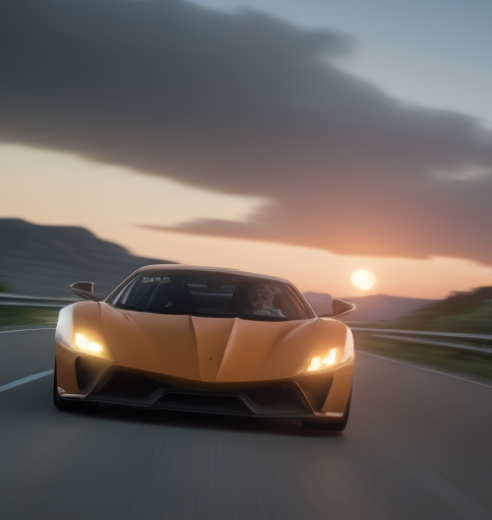

In [3]:
from PIL import Image
from urllib.request import urlopen

# Load image of a supercar
car_path = "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/car.png"
image = Image.open(urlopen(car_path)).convert("RGB")
image

Let's see what the BLIP-2 processor does to the image.

In [4]:
# Preprocess the image
inputs = blip_processor(image, return_tensors="pt").to(device, torch.float16)


**Questions**

- What is the shape of the tensor?
- What can you tell from the shape?
- What are the max and min values of the pixel values?

<details><summary>Click here for answer</summary>

The processor will resize the image into 224 × 224-sized image. So if we have a very wide photo, it will be processed into square photo.
The image is RGB (axis=1 is 3_
Also the pixel values seem to have been normalized, maximum value is 2.0742 and the minimum value is -1.7773



</details>

To display the pixel values as PIL image, we need to do some transformation first.

1. As PIL image is represented as (width, height, channels), but torch tensor is presented as (channels, height, width), we need swap the axis around of the original tensor.  We can use np.einsum() to accompanish this easily in 2 steps:
 -swap position of channel axis to become 3rd axis (ijk->kji)
 -swap position of width and height (ijk->jik)
2. we also need to scale the pixel values to values between 0 and 255, using minmaxscaler. Since minmax scaler works with 2D data, we need to reshape it 2D, by flattening axis=0 (Height) and axis=1 (Width).


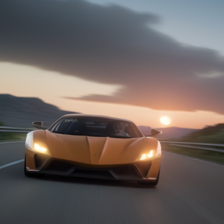

In [5]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Convert to numpy and go from (1, C, H, W) to (W, H, C) in shape
image_inputs = inputs["pixel_values"][0].detach().cpu().numpy()
image_inputs = np.einsum('ijk->kji', image_inputs)
image_inputs = np.einsum('ijk->jik', image_inputs)

# Scale image inputs to 0-255 to represent RGB values
scaler = MinMaxScaler(feature_range=(0, 255))

image_inputs = scaler.fit_transform(image_inputs.reshape(-1, image_inputs.shape[-1])).reshape(image_inputs.shape)
image_inputs = np.array(image_inputs, dtype=np.uint8)

# Convert numpy array to Image
Image.fromarray(image_inputs)

### Preprocessing Text

Let’s continue this exploration of the processor with text instead. First, we
can access the tokenizer used to tokenize the input text

In [6]:
blip_processor.tokenizer

GPT2TokenizerFast(name_or_path='Salesforce/blip2-opt-2.7b', vocab_size=50265, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50265: AddedToken("<image>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

To explore how GPT2Tokenizer works, we can try it out with a small
sentence. We start by converting the sentence to token IDs before converting
them back to tokens:

In [7]:
# Preprocess the text
text = "Her vocalization was remarkably melodic"
token_ids = blip_processor(image, text=text, return_tensors="pt")
token_ids = token_ids.to(device, torch.float16)["input_ids"][0]

# Convert input ids back to tokens
tokens = blip_processor.tokenizer.convert_ids_to_tokens(token_ids)
tokens

['<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '</s>',
 'Her',
 'Ġvocal',
 'ization',
 'Ġwas',
 'Ġremarkably',
 'Ġmel',
 'odic']

When we inspect the tokens, you might notice a strange symbol at the
beginning of some tokens, namely, the Ġ symbol. This is actually supposed
to be a space. However, an internal function takes characters in certain code
points and moves them up by 256 to make them printable. As a result, the
space (code point 32) becomes Ġ (code point 288).

In [13]:
# Replace the space token with an underscore
tokens = [token.replace("Ġ", "_") for token in tokens]
tokens

['<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '</s>',
 'Her',
 '_vocal',
 'ization',
 '_was',
 '_remarkably',
 '_mel',
 'odic']

### Use Case 1: Image Captioning

In [8]:
type(image)

PIL.Image.Image

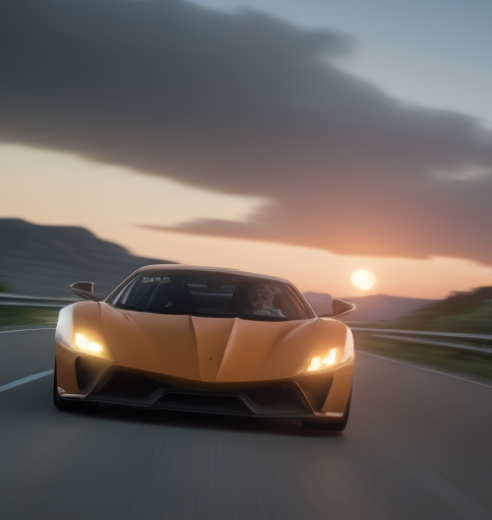

In [9]:
# Load an AI-generated image of a supercar
image = Image.open(urlopen(car_path)).convert("RGB")

# Convert an image into inputs and preprocess it
inputs = blip_processor(image, return_tensors="pt").to(device, torch.float16)
image

In [10]:
inputs['pixel_values'].shape

torch.Size([1, 3, 224, 224])

In [11]:
type(inputs)

transformers.image_processing_base.BatchFeature

In [12]:
# Generate image ids to be passed to the decoder (LLM)
generated_ids = model.generate(**inputs, max_new_tokens=20)

# Generate text from the image ids
generated_text = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)
generated_text = generated_text[0].strip()
generated_text

RuntimeError: shape mismatch: value tensor of shape [81920] cannot be broadcast to indexing result of shape [0]

In [ ]:
url = "https://upload.wikimedia.org/wikipedia/commons/7/70/Rorschach_blot_01.jpg"
image = Image.open(urlopen(url)).convert("RGB")
image

In [ ]:
# Load rorschach image
url = "https://upload.wikimedia.org/wikipedia/commons/7/70/Rorschach_blot_01.jpg"
image = Image.open(urlopen(url)).convert("RGB")

# Generate caption
inputs = blip_processor(image, return_tensors="pt").to(device, torch.float16)
generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)
generated_text = generated_text[0].strip()
generated_text

### Use Case 2: Visual Question Answering

In [ ]:
# Load an AI-generated image of a supercar
image = Image.open(urlopen(car_path)).convert("RGB")

In [ ]:
# Visual Question Answering
prompt = "Question: Write down what you see in this picture. Answer:"

# Process both the image and the prompt
inputs = blip_processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

# Generate text
generated_ids = model.generate(**inputs, max_new_tokens=30)
generated_text = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)
generated_text = generated_text[0].strip()
generated_text

In [ ]:
# Chat-like prompting
prompt = "Question: Write down what you see in this picture. Answer: A sports car driving on the road at sunset. Question: What would it cost me to drive that car? Answer:"

# Generate output
inputs = blip_processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)
generated_ids = model.generate(**inputs, max_new_tokens=30)
generated_text = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)
generated_text = generated_text[0].strip()
generated_text

In [ ]:
from IPython.display import HTML, display
import ipywidgets as widgets

def text_eventhandler(*args):
  question = args[0]["new"]
  if question:
    args[0]["owner"].value = ""

    # Create prompt
    if not memory:
      prompt = " Question: " + question + " Answer:"
    else:
      template = "Question: {} Answer: {}."
      prompt = " ".join(
          [
              template.format(memory[i][0], memory[i][1])
              for i in range(len(memory))
          ]
      ) + " Question: " + question + " Answer:"

    # Generate text
    inputs = blip_processor(image, text=prompt, return_tensors="pt")
    inputs = inputs.to(device, torch.float16)
    generated_ids = model.generate(**inputs, max_new_tokens=100)
    generated_text = blip_processor.batch_decode(
        generated_ids,
        skip_special_tokens=True
    )
    generated_text = generated_text[0].strip().split("Question")[0]

    # Update memory
    memory.append((question, generated_text))

    # Assign to output
    output.append_display_data(HTML("<b>USER:</b> " + question))
    output.append_display_data(HTML("<b>BLIP-2:</b> " + generated_text))
    output.append_display_data(HTML("<br>"))

# Prepare widgets
in_text = widgets.Text()
in_text.continuous_update = False
in_text.observe(text_eventhandler, "value")
output = widgets.Output()
memory = []

# Display chat box
display(
    widgets.VBox(
        children=[output, in_text],
        layout=widgets.Layout(display="inline-flex", flex_flow="column-reverse"),
    )
)